# Importing Libraries

In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import tensorflow as tf
# from tensorflow.keras import layers
import gensim
import sklearn


# 1. Loading the dataset

In [119]:
fake_news = pd.read_csv("Fake.csv")
real_news = pd.read_csv("True.csv")

In [120]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [121]:
real_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


<li>Creating the target variable 'fake', with a value of 1 if an article is fake and 0 otherwise.
<li>Joining both dataframes to form the complete dataframe.</li>

In [122]:
fake_news['fake'] = 1
real_news['fake'] = 0
news = pd.concat([fake_news, real_news])
news.reset_index(inplace=True, drop=True)

In [123]:
news.head()

,title,text,subject,date,fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [124]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   fake     44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [125]:
counts = news['fake'].value_counts()
fake = counts[1]
real = counts[0]
print('The dataset consists of %d fake news articles and %d real news articles' % (fake,real))

The dataset consists of 23481 fake news articles and 21417 real news articles


# 2. Data Cleaning

### 2.1 Missing data

In [126]:
#Check for missing data
news.isna().value_counts()

title  text   subject  date   fake 
False  False  False    False  False    44898
dtype: int64

### 2.2 Duplicate articles

In [127]:
# Check for duplicates
news['all_text'] = news['title'] + ' '+ news['text'] 
num_dup = len(news) - len(news['all_text'].unique())
print('There are a total of %d duplicates in the dataset' % num_dup)

There are a total of 5793 duplicates in the dataset


In [128]:
news.drop_duplicates(subset=['all_text'], inplace = True)
news.shape

(39105, 6)

In [129]:
updated_counts = news['fake'].value_counts()
updated_fake = updated_counts[1]
updated_real = updated_counts[0]
print('After dropping duplicates, the dataset consists of %d fake news articles and %d real news articles' % (updated_fake,updated_real))

After dropping duplicates, the dataset consists of 17908 fake news articles and 21197 real news articles


### 2.3 Removing articles with no text boday

In [132]:
news['length'] = news['text'].map(lambda x: len(x.split()))

news[news['length']==0]['fake'].value_counts()



1    446
0      1
Name: fake, dtype: int64

In [133]:
news = news[news['length'] != 0]
news.shape

(38658, 7)

In [134]:
updated_counts = news['fake'].value_counts()
updated_fake = updated_counts[1]
updated_real = updated_counts[0]
print('After dropping news with no text, the dataset consists of %d fake news articles and %d real news articles' % (updated_fake,updated_real))

After dropping news with no text, the dataset consists of 17462 fake news articles and 21196 real news articles


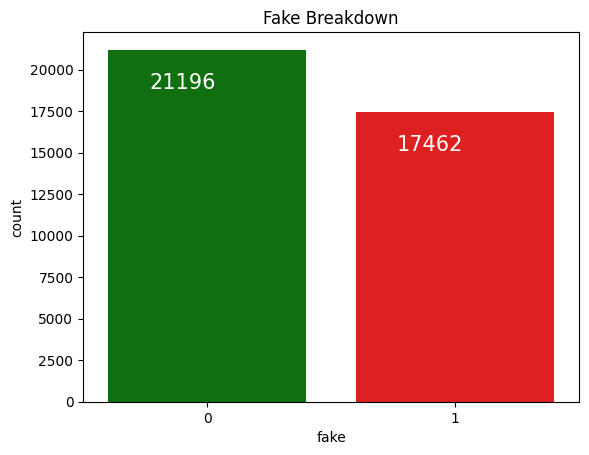

In [135]:
ax = sns.countplot(x='fake', data=news, palette=['g','r'])
ax.set_title('Fake Breakdown')
for i in ax.patches:
    ax.annotate(f'\n{i.get_height()}', (i.get_x() + 0.3, i.get_height()), ha='center', va='top', color='white', size=15)

### 2.4 Removing publisher information for real news
<li>With a quick scan of the real news articles in our dataset, we realise that most texts start off with publisher information, specifically Reuters <b>(eg. 'WASHINGTON (Reuters) -')</b>.</li>
<li>We want to be able to generalise our predictions models to articles from any publisher, hence we drop publisher information from our dataset.</li>

In [17]:
with_publisher_info = news['text'].str.contains('^.+ \(Reuters\) - ', regex=True).sum()
print('A total of %d out of %d real news articles contain publisher information' % (with_publisher_info,updated_real))

A total of 19557 out of 21196 real news articles contain publisher information


In [18]:
news['text'] = news['text'].map(lambda x: re.sub(r'^.+ \(Reuters\) - ','',x))
news[news['fake']== 0]['text']

23481    The head of a conservative Republican faction ...
23482    Transgender people will be allowed for the fir...
23483    The special counsel investigation of links bet...
23484    Trump campaign adviser George Papadopoulos tol...
23485    President Donald Trump called on the U.S. Post...
                               ...                        
44893    NATO allies on Tuesday welcomed President Dona...
44894    LexisNexis, a provider of legal, regulatory an...
44895    In the shadow of disused Soviet-era factories ...
44896    Vatican Secretary of State Cardinal Pietro Par...
44897    Indonesia will buy 11 Sukhoi fighter jets wort...
Name: text, Length: 21196, dtype: object

In [19]:
# update 'all_text' column
news['all_text'] = news['title'] + ' ' + news['text'] 

# 3. Exploratory Data Analysis

### 3.1 Subject Distribution

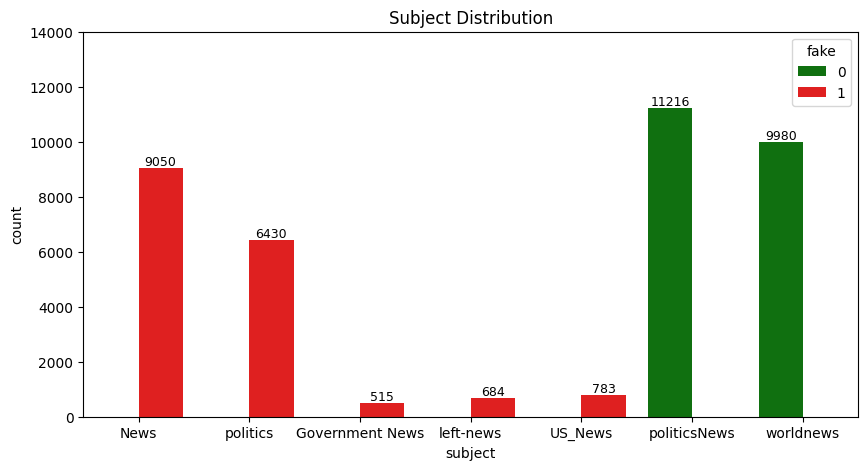

In [21]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x='subject', data=news, hue='fake', palette=['g','r'])
ax.set_title('Subject Distribution')
ax.set(ylim=(0, 14000))
for p in ax.patches:
    ax.annotate(f'\n{p.get_height().astype(int)}', (p.get_x()+0.2, p.get_height() + 1000), ha='center', va='top', color='black', size=9)


### 3.2 Subject distribution by target

<Figure size 1000x500 with 0 Axes>

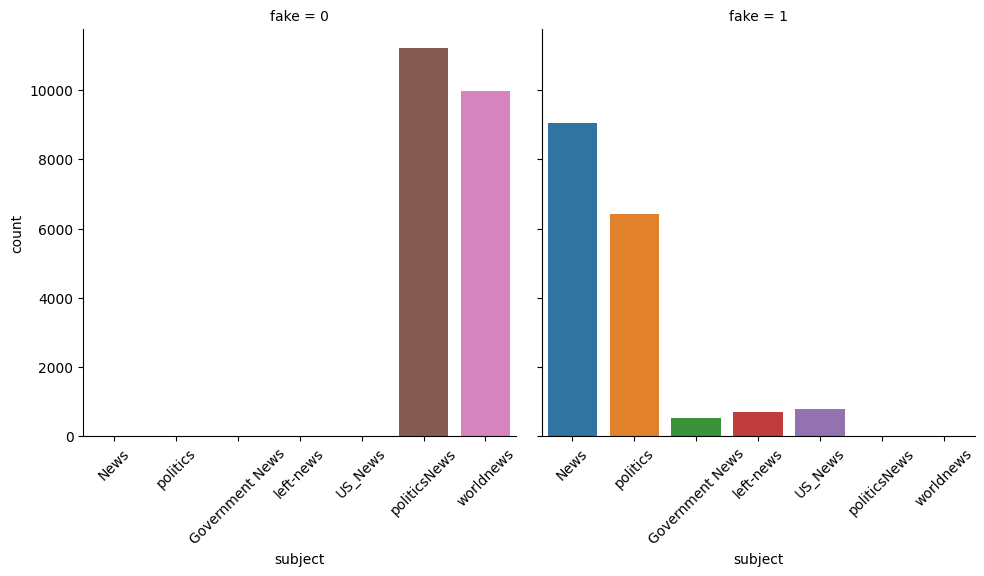

In [22]:
plt.figure(figsize=(10,5))
g = sns.catplot(x="subject", col="fake", data=news, kind="count")

#Rotating the xlabels
g.set_xticklabels(rotation=45)


It appears that all real news fall under either of the subjects 'politicsNews' or 'worldnews', while a significant proportion of fake news are categorised as 'News' or 'politics'.

### 3.3 Word Length Distribution 

<AxesSubplot:xlabel='length', ylabel='Count'>

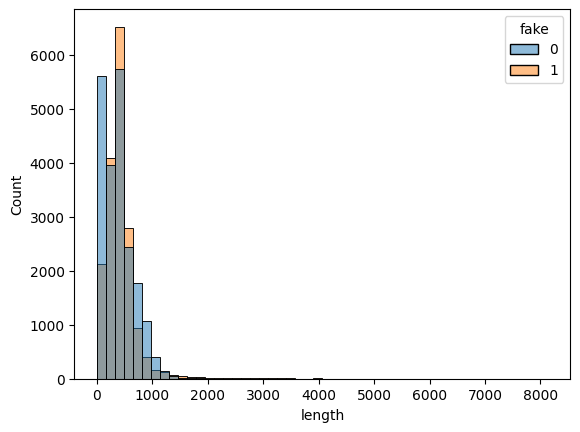

In [23]:
sns.histplot(x='length', data=news, bins = 50, hue='fake')

### 3.4 Word Cloud

In [24]:
from wordcloud import WordCloud, STOPWORDS
#Word Cloud
stopwords = set(STOPWORDS)
def give_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=0
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

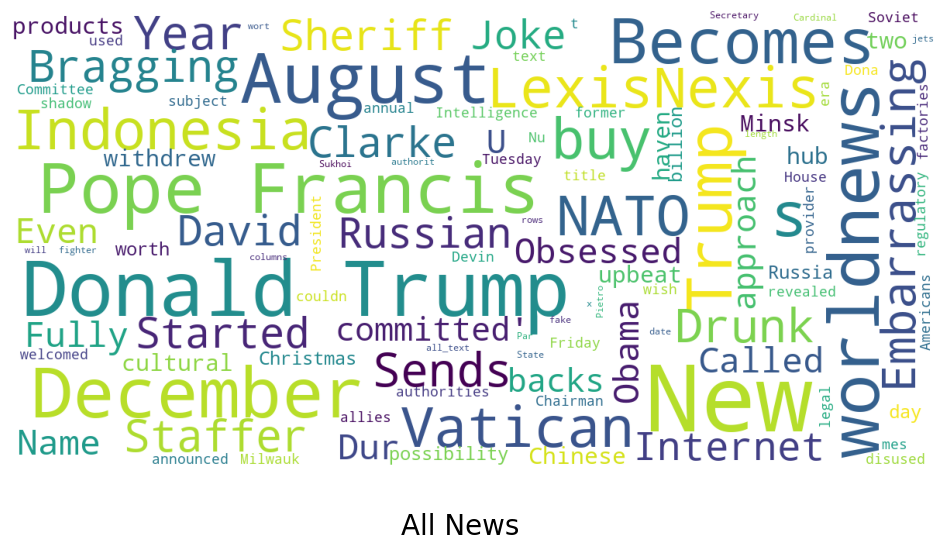

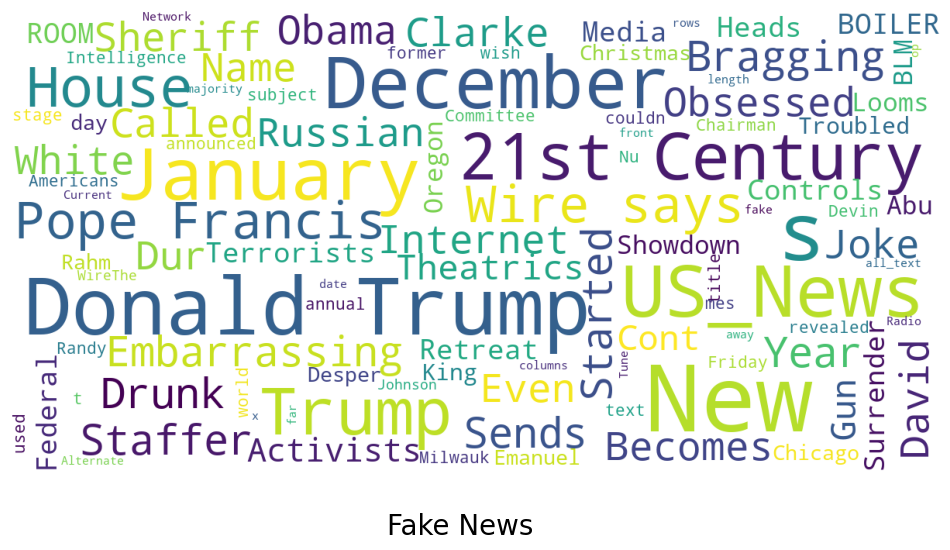

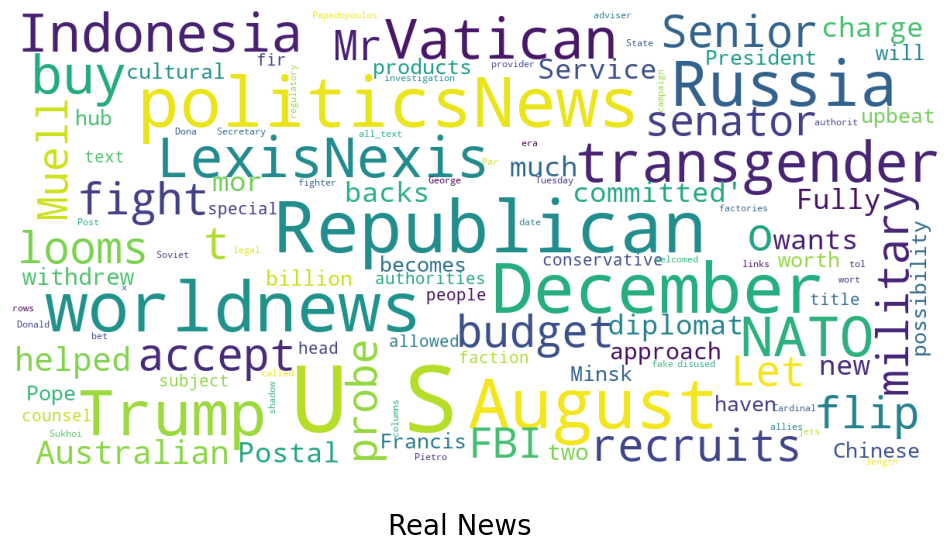

In [25]:
give_wordcloud(news,'All News')
give_wordcloud(news[news['fake'] == 1], 'Fake News')
give_wordcloud(news[news['fake'] == 0], 'Real News')

Fake news shows emotive and loaded language such as 'Drunk' and 'Obsessed', and biased persons such as Donald Trump are often mentioned.
Real news shows distinguished establishments such as 'NATO'and 'Reuters', and does not contain any emotive language. Instead, the words lean more towards factual.

# 4. Feature Engineering - Title + Text

### 4.1 Functions to generate Metadata features from corpus

In [29]:
import string
import re
import nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#Functions
def count_chars(text):
    return len(text)
def count_words(text):
    return len(text.split())
def count_capital_words(text):
    return sum(map(str.isupper,text.split()))
def count_sent(text):
    return len(nltk.sent_tokenize(text))

def getPunctuations(text_col):
    '''
    Parameters
    ----------
    text_col : Series of strings
    
    Returns
    -------
    punctuations : string of all non-alphanumeric & non-space characters
    '''
    regx = re.compile(r'[\W_]')
    res = []
    for i in text_col:
        res.extend(regx.findall(i))
    res = set(res)
    spaces = ['\u200a', '\u200b', '\u200f', '\u202a', '\u200e', '\xa0', '\u202c', '\ufeff', '\n', '\r', '\t', ' ']
    for s in spaces:
        res.remove(s)
    
    punctuations = ''
    for r in res:
        punctuations += r
        
    return punctuations

def count_all_punctuations(text):
    count = 0
    for i in getPunctuations(text):
        count += 1
    return count

def count_words_in_quotes(text):
    x = re.findall(f"{string.punctuation[1]}.{string.punctuation[1]}|{string.punctuation[6]}.{string.punctuation[6]}|“.”|‘.’", text)
    count=0
    if x is None:
        return 0
    else:
        for i in x:
            t=i[1:-1]
            count+=count_words(t)
        return count
def count_unique_words(text):
    return len(set(text.split()))
def count_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

In [ ]:
df = news.copy()

In [30]:
df['char_count'] = df["all_text"].apply(lambda x:count_chars(x))
df['word_count'] = df["all_text"].apply(lambda x:count_words(x))
df['sent_count'] = df["all_text"].apply(lambda x:count_sent(x))
df['capital_word_count'] = df["all_text"].apply(lambda x:count_capital_words(x))
df['quoted_word_count'] = df["all_text"].apply(lambda x:count_words_in_quotes(x))
df['stopword_count'] = df["all_text"].apply(lambda x:count_stopwords(x))
df['unique_word_count'] = df["all_text"].apply(lambda x:count_unique_words(x))
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
df['punct_count'] = df.all_text.apply(lambda s: count(s, string.punctuation))
df['avg_wordlength'] = df['char_count']/df['word_count']
df['avg_sentlength'] = df['word_count']/df['sent_count']
df['unique_vs_words'] = df['unique_word_count']/df['word_count']
df['stopwords_vs_words'] = df['stopword_count']/df['word_count']

In [31]:
df.drop('length', axis=1)

,title,text,subject,date,fake,all_text,char_count,word_count,sent_count,capital_word_count,quoted_word_count,stopword_count,unique_word_count,punct_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,Donald Trump Sends Out Embarrassing New Year’...,2973,507,26,5,0,195,282,122,5.863905,19.500000,0.556213,0.384615
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,Drunk Bragging Trump Staffer Started Russian ...,1968,313,11,3,0,120,209,39,6.287540,28.454545,0.667732,0.383387
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,Sheriff David Clarke Becomes An Internet Joke...,3688,595,25,42,0,220,344,148,6.198319,23.800000,0.578151,0.369748
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,Trump Is So Obsessed He Even Has Obama’s Name...,2853,458,15,6,0,164,278,120,6.229258,30.533333,0.606987,0.358079
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,Pope Francis Just Called Out Donald Trump Dur...,2417,431,19,0,0,197,244,40,5.607889,22.684211,0.566125,0.457077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,NATO allies on Tuesday welcomed President Dona...,worldnews,"August 22, 2017",0,'Fully committed' NATO backs new U.S. approach...,2862,472,15,16,0,183,270,72,6.063559,31.466667,0.572034,0.387712
44894,LexisNexis withdrew two products from Chinese ...,"LexisNexis, a provider of legal, regulatory an...",worldnews,"August 22, 2017",0,LexisNexis withdrew two products from Chinese ...,834,129,6,0,0,46,81,15,6.465116,21.500000,0.627907,0.356589
44895,Minsk cultural hub becomes haven from authorities,In the shadow of disused Soviet-era factories ...,worldnews,"August 22, 2017",0,Minsk cultural hub becomes haven from authorit...,1982,324,16,4,0,133,219,45,6.117284,20.250000,0.675926,0.410494
44896,Vatican upbeat on possibility of Pope Francis ...,Vatican Secretary of State Cardinal Pietro Par...,worldnews,"August 22, 2017",0,Vatican upbeat on possibility of Pope Francis ...,1242,211,8,0,0,83,142,18,5.886256,26.375000,0.672986,0.393365


In [32]:
lowercased = [t.lower() for t in df['all_text']]
tokens = [nltk.word_tokenize(i) for i in lowercased]
tags = [nltk.pos_tag(i) for i in tokens]

from collections import Counter
counts = [Counter(tag for word, tag in i) for i in tags]

#NN is noun, RB is adverb
nouns_count = [i['NN'] for i in counts]
adverb_count = [i['RB'] for i in counts]

df['noun_count'] = nouns_count
df['adverb_count'] = adverb_count

### 4.2 Sentiment Score

In [38]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Getting sentiment values from all_text

analyzer = SentimentIntensityAnalyzer()
df['sentiment_score'] = [analyzer.polarity_scores(x)['compound'] for x in df['all_text']]

In [41]:
df.head()

,title,text,subject,date,fake,all_text,char_count,word_count,sent_count,capital_word_count,...,stopword_count,unique_word_count,punct_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words,noun_count,adverb_count,sentiment_score
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,Donald Trump Sends Out Embarrassing New Year’...,2973,507,26,5,...,195,282,122,5.863905,19.500000,0.556213,0.384615,116,36,-0.9139
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,Drunk Bragging Trump Staffer Started Russian ...,1968,313,11,3,...,120,209,39,6.287540,28.454545,0.667732,0.383387,94,10,-0.7685
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,Sheriff David Clarke Becomes An Internet Joke...,3688,595,25,42,...,220,344,148,6.198319,23.800000,0.578151,0.369748,167,20,-0.9955
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,Trump Is So Obsessed He Even Has Obama’s Name...,2853,458,15,6,...,164,278,120,6.229258,30.533333,0.606987,0.358079,143,24,-0.9269
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,Pope Francis Just Called Out Donald Trump Dur...,2417,431,19,0,...,197,244,40,5.607889,22.684211,0.566125,0.457077,79,16,0.3134


In [40]:
df = df.drop('length',axis=1)
df.iloc[:,6:]

,char_count,word_count,sent_count,capital_word_count,quoted_word_count,stopword_count,unique_word_count,punct_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words,noun_count,adverb_count,sentiment_score
0,2973,507,26,5,0,195,282,122,5.863905,19.500000,0.556213,0.384615,116,36,-0.9139
1,1968,313,11,3,0,120,209,39,6.287540,28.454545,0.667732,0.383387,94,10,-0.7685
2,3688,595,25,42,0,220,344,148,6.198319,23.800000,0.578151,0.369748,167,20,-0.9955
3,2853,458,15,6,0,164,278,120,6.229258,30.533333,0.606987,0.358079,143,24,-0.9269
4,2417,431,19,0,0,197,244,40,5.607889,22.684211,0.566125,0.457077,79,16,0.3134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44893,2862,472,15,16,0,183,270,72,6.063559,31.466667,0.572034,0.387712,100,18,0.1181
44894,834,129,6,0,0,46,81,15,6.465116,21.500000,0.627907,0.356589,36,1,0.5423
44895,1982,324,16,4,0,133,219,45,6.117284,20.250000,0.675926,0.410494,74,15,0.9818
44896,1242,211,8,0,0,83,142,18,5.886256,26.375000,0.672986,0.393365,53,8,0.8100


### 4.3 Saving to CSV

In [42]:
df.to_csv('all_text.csv', index=False)

# 5. Feature Engineering - Title 

In [43]:
df2 = df[['title','subject', 'fake']]
df2.head()

,title,subject,fake
0,Donald Trump Sends Out Embarrassing New Year’...,News,1
1,Drunk Bragging Trump Staffer Started Russian ...,News,1
2,Sheriff David Clarke Becomes An Internet Joke...,News,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,News,1
4,Pope Francis Just Called Out Donald Trump Dur...,News,1


### 5.1 Generating Metadata Features

In [44]:
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

df2['char_count'] = df2["title"].apply(lambda x:count_chars(x))
df2['word_count'] = df2["title"].apply(lambda x:count_words(x))
df2['sent_count'] = df2["title"].apply(lambda x:count_sent(x))
df2['capital_word_count'] = df2["title"].apply(lambda x:count_capital_words(x))
df2['quoted_word_count'] = df2["title"].apply(lambda x:count_words_in_quotes(x))
df2['stopword_count'] = df2["title"].apply(lambda x:count_stopwords(x))
df2['unique_word_count'] = df2["title"].apply(lambda x:count_unique_words(x))
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
df2['punct_count'] = df2.title.apply(lambda s: count(s, string.punctuation))
df2['avg_wordlength'] = df2['char_count']/df2['word_count']
df2['avg_sentlength'] = df2['word_count']/df2['sent_count']
df2['unique_vs_words'] = df2['unique_word_count']/df2['word_count']
df2['stopwords_vs_words'] = df2['stopword_count']/df2['word_count']


lowercased2 = [t.lower() for t in df2['title']]
tokens2 = [nltk.word_tokenize(i) for i in lowercased2]
tags2 = [nltk.pos_tag(i) for i in tokens2]
counts2 = [Counter(tag for word, tag in i) for i in tags2]
#N is noun, RB is adverb
nouns_count2 = [i['NN'] for i in counts2]
adverb_count2 = [i['RB'] for i in counts2]

df2['noun_count'] = nouns_count2
df2['adverb_count'] = adverb_count2


# Getting sentiment values from title
analyzer = SentimentIntensityAnalyzer()
df2['sentiment_score'] = [analyzer.polarity_scores(x)['compound'] for x in df2['title']]

/var/folders/9_/bm0l5nks16x5pxll_w26vq5h0000gn/T/ipykernel_22001/2868880243.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['char_count'] = df2["title"].apply(lambda x:count_chars(x))
/var/folders/9_/bm0l5nks16x5pxll_w26vq5h0000gn/T/ipykernel_22001/2868880243.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['word_count'] = df2["title"].apply(lambda x:count_words(x))
/var/folders/9_/bm0l5nks16x5pxll_w26vq5h0000gn/T/ipykernel_22001/2868880243.py:6: SettingWithCopyWarning: 
A value is trying to 

In [45]:
df2.head()

,title,subject,fake,char_count,word_count,sent_count,capital_word_count,quoted_word_count,stopword_count,unique_word_count,punct_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words,noun_count,adverb_count,sentiment_score
0,Donald Trump Sends Out Embarrassing New Year’...,News,1,79,12,1,0,0,2,12,1,6.583333,12.0,1.0,0.166667,5,0,-0.7096
1,Drunk Bragging Trump Staffer Started Russian ...,News,1,69,8,1,0,0,0,8,0,8.625000,8.0,1.0,0.000000,5,0,-0.3400
2,Sheriff David Clarke Becomes An Internet Joke...,News,1,90,15,1,0,0,0,15,0,6.000000,15.0,1.0,0.000000,7,0,-0.2960
3,Trump Is So Obsessed He Even Has Obama’s Name...,News,1,78,14,1,1,0,1,14,2,5.571429,14.0,1.0,0.071429,3,2,-0.3052
4,Pope Francis Just Called Out Donald Trump Dur...,News,1,70,11,1,0,0,0,11,0,6.363636,11.0,1.0,0.000000,5,1,0.0000


### 5.2 Saving to CSV

In [46]:
df2.to_csv("title.csv", index=False)

In [47]:
df2.iloc[:,2:]

,fake,char_count,word_count,sent_count,capital_word_count,quoted_word_count,stopword_count,unique_word_count,punct_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words,noun_count,adverb_count,sentiment_score
0,1,79,12,1,0,0,2,12,1,6.583333,12.0,1.0,0.166667,5,0,-0.7096
1,1,69,8,1,0,0,0,8,0,8.625000,8.0,1.0,0.000000,5,0,-0.3400
2,1,90,15,1,0,0,0,15,0,6.000000,15.0,1.0,0.000000,7,0,-0.2960
3,1,78,14,1,1,0,1,14,2,5.571429,14.0,1.0,0.071429,3,2,-0.3052
4,1,70,11,1,0,0,0,11,0,6.363636,11.0,1.0,0.000000,5,1,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44893,0,61,9,1,2,0,1,9,4,6.777778,9.0,1.0,0.111111,2,1,0.2333
44894,0,52,7,1,0,0,1,7,0,7.428571,7.0,1.0,0.142857,1,0,0.0000
44895,0,49,7,1,0,0,2,7,0,7.000000,7.0,1.0,0.285714,1,1,0.0000
44896,0,61,9,1,0,0,2,9,0,6.777778,9.0,1.0,0.222222,5,0,0.0000


# 6. Using only title

In [304]:
df2 = pd.read_csv("title.csv")
df2.head()

,title,subject,fake,char_count,word_count,sent_count,capital_word_count,quoted_word_count,stopword_count,unique_word_count,punct_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words,noun_count,adverb_count,sentiment_score
0,Donald Trump Sends Out Embarrassing New Year’...,News,1,79,12,1,0,0,2,12,1,6.583333,12.0,1.0,0.166667,5,0,-0.7096
1,Drunk Bragging Trump Staffer Started Russian ...,News,1,69,8,1,0,0,0,8,0,8.625000,8.0,1.0,0.000000,5,0,-0.3400
2,Sheriff David Clarke Becomes An Internet Joke...,News,1,90,15,1,0,0,0,15,0,6.000000,15.0,1.0,0.000000,7,0,-0.2960
3,Trump Is So Obsessed He Even Has Obama’s Name...,News,1,78,14,1,1,0,1,14,2,5.571429,14.0,1.0,0.071429,3,2,-0.3052
4,Pope Francis Just Called Out Donald Trump Dur...,News,1,70,11,1,0,0,0,11,0,6.363636,11.0,1.0,0.000000,5,1,0.0000


In [305]:
X_title = df2.iloc[:,3:]
y_title = df2['fake']

In [306]:
X_title.head()

,char_count,word_count,sent_count,capital_word_count,quoted_word_count,stopword_count,unique_word_count,punct_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words,noun_count,adverb_count,sentiment_score
0,79,12,1,0,0,2,12,1,6.583333,12.0,1.0,0.166667,5,0,-0.7096
1,69,8,1,0,0,0,8,0,8.625000,8.0,1.0,0.000000,5,0,-0.3400
2,90,15,1,0,0,0,15,0,6.000000,15.0,1.0,0.000000,7,0,-0.2960
3,78,14,1,1,0,1,14,2,5.571429,14.0,1.0,0.071429,3,2,-0.3052
4,70,11,1,0,0,0,11,0,6.363636,11.0,1.0,0.000000,5,1,0.0000


In [307]:
X_train_title, X_test_title, y_train_title, y_test_title = train_test_split(X_title, y_title, test_size=0.2, shuffle=True, random_state=1) #20% test

### 6.1 Logistic Regression

In [308]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit


lr_clf_title = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=1))
])

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=1)
lr_cv_results_title = cross_validate(lr_clf_title, X_train_title, y_train_title, cv=cv, return_train_score=True)

In [309]:
lr_cv_results_title

{'fit_time': array([0.20601892, 0.1988821 , 0.19030619, 0.32583499, 0.17421484,
        0.14989591, 0.19822907, 0.16369104, 0.223979  , 0.16799688]),
 'score_time': array([0.00575614, 0.00355315, 0.00520873, 0.0046711 , 0.00397801,
        0.00335002, 0.00308919, 0.00441194, 0.00402308, 0.00423694]),
 'test_score': array([0.94002586, 0.94794698, 0.94406725, 0.94148076, 0.94180407,
        0.94358228, 0.94115745, 0.94228904, 0.94083414, 0.9442289 ]),
 'train_score': array([0.9434519 , 0.94135004, 0.94232013, 0.94320938, 0.94288601,
        0.94211803, 0.94316896, 0.94292643, 0.94292643, 0.94236055])}

In [310]:
print(f'Time for fitting classifier on the train set: {lr_cv_results_title["fit_time"].mean()}')
print(f'Time for scoring classifier on the validation set: {lr_cv_results_title["score_time"].mean()}')
print(f'Accuracy of Train: {lr_cv_results_title["train_score"].mean()}')
print(f'Accuracy of Validation: {lr_cv_results_title["test_score"].mean()}')

Time for fitting classifier on the train set: 0.1999048948287964
Time for scoring classifier on the validation set: 0.004227828979492187
Accuracy of Train: 0.9426717865804365
Accuracy of Validation: 0.9427416747494343


### 6.2 Naive Bayes

In [311]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import Normalizer

gnb_clf_title = Pipeline([
    ('scale', Normalizer()),
    ('clf', GaussianNB())
])

gnb_cv_results_title = cross_validate(gnb_clf_title, X_train_title, y_train_title, cv=cv, return_train_score=True)

In [312]:
gnb_cv_results_title

{'fit_time': array([0.02450728, 0.02813125, 0.02128911, 0.02741504, 0.0217402 ,
        0.02062607, 0.020962  , 0.02020979, 0.02204013, 0.01921082]),
 'score_time': array([0.00799584, 0.00622106, 0.00510216, 0.00438809, 0.00494719,
        0.00425601, 0.00360608, 0.00489497, 0.0035708 , 0.00485921]),
 'test_score': array([0.92935661, 0.93598448, 0.93404462, 0.92870999, 0.92709344,
        0.93452958, 0.93178144, 0.93129648, 0.93388296, 0.93614614]),
 'train_score': array([0.93298302, 0.93168957, 0.93136621, 0.9327405 , 0.92914309,
        0.93168957, 0.93221504, 0.93367017, 0.93229588, 0.93080032])}

In [313]:
print(f'Time for fitting classifier on the train set: {gnb_cv_results_title["fit_time"].mean()}')
print(f'Time for scoring classifier on the validation set: {gnb_cv_results_title["score_time"].mean()}')
print(f'Accuracy of Train: {gnb_cv_results_title["train_score"].mean()}')
print(f'Accuracy of Validation: {gnb_cv_results_title["test_score"].mean()}')

Time for fitting classifier on the train set: 0.022613167762756348
Time for scoring classifier on the validation set: 0.004984140396118164
Accuracy of Train: 0.9318593371059013
Accuracy of Validation: 0.9322825735531847


### 6.3 SVM

In [314]:
from sklearn.svm import SVC

svm_clf_title = Pipeline([
    ('scale', StandardScaler()),
    ('clf', SVC(random_state=1))
])

svm_cv_results_title = cross_validate(svm_clf_title, X_train_title, y_train_title, cv=cv, return_train_score=True)

In [315]:
svm_cv_results_title

{'fit_time': array([8.47372699, 9.35550499, 8.23018336, 8.5231092 , 8.92714524,
        6.36918902, 7.10802364, 9.91393995, 7.40394711, 9.16447592]),
 'score_time': array([3.51560807, 3.3779161 , 3.13882375, 3.57650781, 3.73513103,
        2.90482593, 3.31765819, 3.81584978, 3.63774014, 3.23954034]),
 'test_score': array([0.94746201, 0.95457485, 0.95489816, 0.95376657, 0.95134174,
        0.95279664, 0.9500485 , 0.95085677, 0.95279664, 0.9547365 ]),
 'train_score': array([0.95533549, 0.95408246, 0.95347615, 0.95363783, 0.95468876,
        0.95412288, 0.95464834, 0.95485044, 0.95444624, 0.95359741])}

In [316]:
print(f'Time for fitting classifier on the train set: {svm_cv_results_title["fit_time"].mean()}')
print(f'Time for scoring classifier on the validation set: {svm_cv_results_title["score_time"].mean()}')
print(f'Accuracy of Train: {svm_cv_results_title["train_score"].mean()}')
print(f'Accuracy of Validation: {svm_cv_results_title["test_score"].mean()}')

Time for fitting classifier on the train set: 8.346924543380737
Time for scoring classifier on the validation set: 3.425960111618042
Accuracy of Train: 0.9542886014551334
Accuracy of Validation: 0.9523278370514063


### 6.4 Random Forest

In [317]:
from sklearn.ensemble import RandomForestClassifier

rf_clf_title = Pipeline([
    ('scale', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=1))
])

rf_cv_results_title = cross_validate(rf_clf_title, X_train_title, y_train_title, cv=cv, return_train_score=True)

In [318]:
rf_cv_results_title

{'fit_time': array([2.1601181 , 2.46026921, 2.39822507, 2.57923317, 2.39874506,
        2.29699993, 2.16644573, 2.13497281, 2.02687788, 2.46322513]),
 'score_time': array([0.11756897, 0.10961819, 0.118186  , 0.1454289 , 0.12753701,
        0.12430906, 0.11793113, 0.14323616, 0.11809683, 0.14182806]),
 'test_score': array([0.94374394, 0.94827029, 0.94616877, 0.94697704, 0.9409958 ,
        0.94746201, 0.94390559, 0.94390559, 0.94633042, 0.94616877]),
 'train_score': array([0.99882781, 0.99890865, 0.99907033, 0.99882781, 0.99894907,
        0.99890865, 0.99866613, 0.99894907, 0.99894907, 0.99882781])}

In [319]:
print(f'Time for fitting classifier on the train set: {rf_cv_results_title["fit_time"].mean()}')
print(f'Time for scoring classifier on the validation set: {rf_cv_results_title["score_time"].mean()}')
print(f'Accuracy of Train: {rf_cv_results_title["train_score"].mean()}')
print(f'Accuracy of Validation: {rf_cv_results_title["test_score"].mean()}')

Time for fitting classifier on the train set: 2.308511209487915
Time for scoring classifier on the validation set: 0.1263740301132202
Accuracy of Train: 0.9988884397736459
Accuracy of Validation: 0.945392822502425


### 6.5 XGBoost

In [320]:
from xgboost import XGBClassifier

xgboost_clf_title = Pipeline([
    ('scale', StandardScaler()),
    ('clf', XGBClassifier(random_state=1))
])

xgboost_cv_results_title = cross_validate(xgboost_clf_title, X_train_title, y_train_title, cv=cv, return_train_score=True)

In [321]:
xgboost_cv_results_title

{'fit_time': array([1.71045995, 1.63550901, 1.50978827, 1.51870513, 1.39557219,
        1.45448399, 1.473598  , 1.37874794, 1.39022589, 1.36132574]),
 'score_time': array([0.02218819, 0.02232504, 0.02306485, 0.0270381 , 0.02197695,
        0.02251029, 0.02537394, 0.02095294, 0.02181911, 0.02146411]),
 'test_score': array([0.94519884, 0.95085677, 0.95118008, 0.94988684, 0.94600711,
        0.95101843, 0.94843194, 0.94681539, 0.94827029, 0.95053346]),
 'train_score': array([0.9525869 , 0.95133387, 0.95161681, 0.95226354, 0.95323363,
        0.95153597, 0.95291027, 0.95181892, 0.95157639, 0.95185934])}

In [322]:
print(f'Time for fitting classifier on the train set: {xgboost_cv_results_title["fit_time"].mean()}')
print(f'Time for scoring classifier on the validation set: {xgboost_cv_results_title["score_time"].mean()}')
print(f'Accuracy of Train: {xgboost_cv_results_title["train_score"].mean()}')
print(f'Accuracy of Validation: {xgboost_cv_results_title["test_score"].mean()}')

Time for fitting classifier on the train set: 1.4828416109085083
Time for scoring classifier on the validation set: 0.02287135124206543
Accuracy of Train: 0.9520735650767987
Accuracy of Validation: 0.9488199159392176


In [323]:
results_title = pd.DataFrame(index=['Logistic Regression', 'Gaussian Naive Bayes', 'Support Vector Machine', 'Random Forest', 'XGBoost'])

results_title.loc['Logistic Regression', 'train_acc'] = lr_cv_results_title["train_score"].mean()
results_title.loc['Logistic Regression', 'val_acc'] = lr_cv_results_title["test_score"].mean()
results_title.loc['Logistic Regression', 'fit_time'] = lr_cv_results_title["fit_time"].mean()

results_title.loc['Gaussian Naive Bayes', 'train_acc'] = gnb_cv_results_title["train_score"].mean()
results_title.loc['Gaussian Naive Bayes', 'val_acc'] = gnb_cv_results_title["test_score"].mean()
results_title.loc['Gaussian Naive Bayes', 'fit_time'] = gnb_cv_results_title["fit_time"].mean()

results_title.loc['Support Vector Machine', 'train_acc'] = svm_cv_results_title["train_score"].mean()
results_title.loc['Support Vector Machine', 'val_acc'] = svm_cv_results_title["test_score"].mean()
results_title.loc['Support Vector Machine', 'fit_time'] = svm_cv_results_title["fit_time"].mean()

results_title.loc['Random Forest', 'train_acc'] = rf_cv_results_title["train_score"].mean()
results_title.loc['Random Forest', 'val_acc'] = rf_cv_results_title["test_score"].mean()
results_title.loc['Random Forest', 'fit_time'] = rf_cv_results_title["fit_time"].mean()

results_title.loc['XGBoost', 'train_acc'] = xgboost_cv_results_title["train_score"].mean()
results_title.loc['XGBoost', 'val_acc'] = xgboost_cv_results_title["test_score"].mean()
results_title.loc['XGBoost', 'fit_time'] = xgboost_cv_results_title["fit_time"].mean()

In [324]:
results_title

,train_acc,val_acc,fit_time
Logistic Regression,0.942672,0.942742,0.199905
Gaussian Naive Bayes,0.931859,0.932283,0.022613
Support Vector Machine,0.954289,0.952328,8.346925
Random Forest,0.998888,0.945393,2.308511
XGBoost,0.952074,0.948820,1.482842


# 7. Using All Text

In [325]:
df = pd.read_csv("all_text.csv")
df.head()

,title,text,subject,date,fake,all_text,char_count,word_count,sent_count,capital_word_count,...,stopword_count,unique_word_count,punct_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words,noun_count,adverb_count,sentiment_score
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,Donald Trump Sends Out Embarrassing New Year’...,2973,507,26,5,...,195,282,122,5.863905,19.500000,0.556213,0.384615,116,36,-0.9139
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,Drunk Bragging Trump Staffer Started Russian ...,1968,313,11,3,...,120,209,39,6.287540,28.454545,0.667732,0.383387,94,10,-0.7685
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,Sheriff David Clarke Becomes An Internet Joke...,3688,595,25,42,...,220,344,148,6.198319,23.800000,0.578151,0.369748,167,20,-0.9955
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,Trump Is So Obsessed He Even Has Obama’s Name...,2853,458,15,6,...,164,278,120,6.229258,30.533333,0.606987,0.358079,143,24,-0.9269
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,Pope Francis Just Called Out Donald Trump Dur...,2417,431,19,0,...,197,244,40,5.607889,22.684211,0.566125,0.457077,79,16,0.3134


In [326]:
X = df.iloc[:,6:]
y = df['fake']

In [327]:
X.head()

,char_count,word_count,sent_count,capital_word_count,quoted_word_count,stopword_count,unique_word_count,punct_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words,noun_count,adverb_count,sentiment_score
0,2973,507,26,5,0,195,282,122,5.863905,19.500000,0.556213,0.384615,116,36,-0.9139
1,1968,313,11,3,0,120,209,39,6.287540,28.454545,0.667732,0.383387,94,10,-0.7685
2,3688,595,25,42,0,220,344,148,6.198319,23.800000,0.578151,0.369748,167,20,-0.9955
3,2853,458,15,6,0,164,278,120,6.229258,30.533333,0.606987,0.358079,143,24,-0.9269
4,2417,431,19,0,0,197,244,40,5.607889,22.684211,0.566125,0.457077,79,16,0.3134


In [328]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state = 1) #20% test

### 7.1 Logistic Regression

In [329]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit


lr_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=1))
])

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=1)
lr_cv_results = cross_validate(lr_clf, X_train, y_train, cv=cv, return_train_score=True)

/Users/jiawei/opt/anaconda3/envs/BT4222/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jiawei/opt/anaconda3/envs/BT4222/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

In [330]:
lr_cv_results

{'fit_time': array([0.31679201, 0.27346873, 0.297894  , 0.23842168, 0.22559118,
        0.20967412, 0.31553006, 0.33550811, 0.30349207, 0.24967194]),
 'score_time': array([0.00427318, 0.00616312, 0.00911808, 0.00442338, 0.00344086,
        0.00433087, 0.00620508, 0.00627398, 0.00380921, 0.00295687]),
 'test_score': array([0.86129971, 0.85693501, 0.8533786 , 0.86663434, 0.86420951,
        0.8580666 , 0.85984481, 0.86744261, 0.85305529, 0.86372454]),
 'train_score': array([0.86046888, 0.85877122, 0.86176233, 0.8589329 , 0.85856912,
        0.86046888, 0.85957963, 0.85711399, 0.86228779, 0.85877122])}

In [331]:
print(f'Time for fitting classifier on the train set: {lr_cv_results["fit_time"].mean()}')
print(f'Time for scoring classifier on the validation set: {lr_cv_results["score_time"].mean()}')
print(f'Accuracy of Train: {lr_cv_results["train_score"].mean()}')
print(f'Accuracy of Validation: {lr_cv_results["test_score"].mean()}')

Time for fitting classifier on the train set: 0.2766043901443481
Time for scoring classifier on the validation set: 0.00509946346282959
Accuracy of Train: 0.8596725949878741
Accuracy of Validation: 0.8604591011962496


### 7.2 Naive Bayes

In [332]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import Normalizer

gnb_clf = Pipeline([
    ('scale', Normalizer()),
    ('clf', GaussianNB())
])

gnb_cv_results = cross_validate(gnb_clf, X_train, y_train, cv=cv, return_train_score=True)

In [333]:
gnb_cv_results

{'fit_time': array([0.0266242 , 0.05525613, 0.02608681, 0.04306388, 0.02371001,
        0.02112103, 0.01869392, 0.01980019, 0.02669191, 0.02695584]),
 'score_time': array([0.00747371, 0.00431776, 0.00666213, 0.00669432, 0.004179  ,
        0.00501513, 0.00366211, 0.00426078, 0.00595284, 0.00544596]),
 'test_score': array([0.69915939, 0.70400905, 0.68913676, 0.68461041, 0.6933398 ,
        0.68962173, 0.69689622, 0.6962496 , 0.6871969 , 0.69608794]),
 'train_score': array([0.69122878, 0.70145513, 0.68823767, 0.68864188, 0.68569119,
        0.69409863, 0.69090542, 0.69664511, 0.69353274, 0.68755053])}

In [334]:
print(f'Time for fitting classifier on the train set: {gnb_cv_results["fit_time"].mean()}')
print(f'Time for scoring classifier on the validation set: {gnb_cv_results["score_time"].mean()}')
print(f'Accuracy of Train: {gnb_cv_results["train_score"].mean()}')
print(f'Accuracy of Validation: {gnb_cv_results["test_score"].mean()}')

Time for fitting classifier on the train set: 0.028800392150878908
Time for scoring classifier on the validation set: 0.005366373062133789
Accuracy of Train: 0.6917987065481003
Accuracy of Validation: 0.6936307791787908


### 7.3 SVM

In [335]:
from sklearn.svm import SVC

svm_clf = Pipeline([
    ('scale', StandardScaler()),
    ('clf', SVC(random_state=1))
])

svm_cv_results = cross_validate(svm_clf, X_train, y_train, cv=cv, return_train_score=True)

In [336]:
svm_cv_results

{'fit_time': array([15.83650875, 15.21280122, 14.66059279, 15.70920587, 13.0704639 ,
        12.91868091, 20.1200161 , 19.08440685, 14.61764789, 14.77302003]),
 'score_time': array([6.92128205, 6.9949801 , 5.92910528, 6.86502504, 5.53787613,
        5.59414315, 6.53958297, 7.17445302, 7.59994817, 5.76715112]),
 'test_score': array([0.90413838, 0.90171355, 0.90268348, 0.90656321, 0.90753314,
        0.90462334, 0.90413838, 0.909473  , 0.89896541, 0.91189783]),
 'train_score': array([0.90909458, 0.90901374, 0.90788197, 0.90743735, 0.90800323,
        0.90763945, 0.90747777, 0.90739693, 0.90978173, 0.90541633])}

In [337]:
print(f'Time for fitting classifier on the train set: {svm_cv_results["fit_time"].mean()}')
print(f'Time for scoring classifier on the validation set: {svm_cv_results["score_time"].mean()}')
print(f'Accuracy of Train: {svm_cv_results["train_score"].mean()}')
print(f'Accuracy of Validation: {svm_cv_results["test_score"].mean()}')

Time for fitting classifier on the train set: 15.600334429740906
Time for scoring classifier on the validation set: 6.492354702949524
Accuracy of Train: 0.907914308811641
Accuracy of Validation: 0.9051729712253476


### 7.4 Random Forest

In [338]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline([
    ('scale', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=1))
])

rf_cv_results = cross_validate(rf_clf, X_train, y_train, cv=cv, return_train_score=True)

In [339]:
rf_cv_results

{'fit_time': array([8.41277695, 5.58420205, 5.06662679, 4.90041709, 5.59103107,
        5.02245498, 5.35780311, 4.92479587, 4.83327174, 5.4234488 ]),
 'score_time': array([0.34281993, 0.1196599 , 0.12223005, 0.13938904, 0.13423896,
        0.12737203, 0.11662817, 0.12787509, 0.1297152 , 0.15174723]),
 'test_score': array([0.90139024, 0.90058196, 0.90203686, 0.90446169, 0.904785  ,
        0.90397672, 0.90543162, 0.90575493, 0.89993534, 0.91319108]),
 'train_score': array([1.        , 0.99995958, 0.99995958, 1.        , 0.99995958,
        0.99995958, 1.        , 1.        , 1.        , 1.        ])}

In [340]:
print(f'Time for fitting classifier on the train set: {rf_cv_results["fit_time"].mean()}')
print(f'Time for scoring classifier on the validation set: {rf_cv_results["score_time"].mean()}')
print(f'Accuracy of Train: {rf_cv_results["train_score"].mean()}')
print(f'Accuracy of Validation: {rf_cv_results["test_score"].mean()}')

Time for fitting classifier on the train set: 5.511682844161987
Time for scoring classifier on the validation set: 0.15116755962371825
Accuracy of Train: 0.9999838318512531
Accuracy of Validation: 0.9041545425153572


### 7.5 XGBoost

In [341]:
from xgboost import XGBClassifier

xgboost_clf = Pipeline([
    ('scale', StandardScaler()),
    ('clf', XGBClassifier(random_state=1))
])

xgboost_cv_results = cross_validate(xgboost_clf, X_train, y_train, cv=cv, return_train_score=True)

In [342]:
xgboost_cv_results

{'fit_time': array([1.90868592, 1.89333081, 1.94143105, 1.68728399, 1.85398602,
        1.82523704, 1.72568727, 1.74078417, 1.74526787, 1.59783196]),
 'score_time': array([0.021415  , 0.02410221, 0.02121997, 0.02148414, 0.02126217,
        0.02363706, 0.02108407, 0.02152681, 0.02097392, 0.0208919 ]),
 'test_score': array([0.89104429, 0.89185257, 0.89395409, 0.89945037, 0.8942774 ,
        0.89460071, 0.89476237, 0.90074361, 0.89314581, 0.90607824]),
 'train_score': array([0.90626516, 0.90505255, 0.90412288, 0.90307195, 0.90493129,
        0.90323363, 0.90388036, 0.90254648, 0.9041633 , 0.90194018])}

In [343]:
print(f'Time for fitting classifier on the train set: {xgboost_cv_results["fit_time"].mean()}')
print(f'Time for scoring classifier on the validation set: {xgboost_cv_results["score_time"].mean()}')
print(f'Accuracy of Train: {xgboost_cv_results["train_score"].mean()}')
print(f'Accuracy of Validation: {xgboost_cv_results["test_score"].mean()}')

Time for fitting classifier on the train set: 1.7919526100158691
Time for scoring classifier on the validation set: 0.021759724617004393
Accuracy of Train: 0.9039207760711401
Accuracy of Validation: 0.8959909473003556


In [344]:
results_all_text = pd.DataFrame(index=['Logistic Regression', 'Gaussian Naive Bayes', 'Support Vector Machine', 'Random Forest', 'XGBoost'])

results_all_text.loc['Logistic Regression', 'train_acc'] = lr_cv_results["train_score"].mean()
results_all_text.loc['Logistic Regression', 'val_acc'] = lr_cv_results["test_score"].mean()
results_all_text.loc['Logistic Regression', 'fit_time'] = lr_cv_results["fit_time"].mean()

results_all_text.loc['Gaussian Naive Bayes', 'train_acc'] = gnb_cv_results["train_score"].mean()
results_all_text.loc['Gaussian Naive Bayes', 'val_acc'] = gnb_cv_results["test_score"].mean()
results_all_text.loc['Gaussian Naive Bayes', 'fit_time'] = gnb_cv_results["fit_time"].mean()

results_all_text.loc['Support Vector Machine', 'train_acc'] = svm_cv_results["train_score"].mean()
results_all_text.loc['Support Vector Machine', 'val_acc'] = svm_cv_results["test_score"].mean()
results_all_text.loc['Support Vector Machine', 'fit_time'] = svm_cv_results["fit_time"].mean()

results_all_text.loc['Random Forest', 'train_acc'] = rf_cv_results["train_score"].mean()
results_all_text.loc['Random Forest', 'val_acc'] = rf_cv_results["test_score"].mean()
results_all_text.loc['Random Forest', 'fit_time'] = rf_cv_results["fit_time"].mean()

results_all_text.loc['XGBoost', 'train_acc'] = xgboost_cv_results["train_score"].mean()
results_all_text.loc['XGBoost', 'val_acc'] = xgboost_cv_results["test_score"].mean()
results_all_text.loc['XGBoost', 'fit_time'] = xgboost_cv_results["fit_time"].mean()

In [345]:
results_all_text

,train_acc,val_acc,fit_time
Logistic Regression,0.859673,0.860459,0.276604
Gaussian Naive Bayes,0.691799,0.693631,0.028800
Support Vector Machine,0.907914,0.905173,15.600334
Random Forest,0.999984,0.904155,5.511683
XGBoost,0.903921,0.895991,1.791953


# Display results

In [346]:
from IPython.display import display_html 

results_title_style = results_title.style.set_table_attributes("style='display:inline; margin-right:20px;'").set_caption("Title Only")
results_all_text_style = results_all_text.style.set_table_attributes("style='display:inline'").set_caption("Title & Text")

display_html(results_title_style._repr_html_() + results_all_text_style._repr_html_(), raw=True)

,train_acc,val_acc,fit_time
Logistic Regression,0.942672,0.942742,0.199905
Gaussian Naive Bayes,0.931859,0.932283,0.022613
Support Vector Machine,0.954289,0.952328,8.346925
Random Forest,0.998888,0.945393,2.308511
XGBoost,0.952074,0.948820,1.482842
,train_acc,val_acc,fit_time
Logistic Regression,0.859673,0.860459,0.276604
Gaussian Naive Bayes,0.691799,0.693631,0.028800
Support Vector Machine,0.907914,0.905173,15.600334
Random Forest,0.999984,0.904155,5.511683


1. SVM takes the longest to fit across both experiments
2. For title only, although SVM performed the best, XGBoost wasn't far off in terms of validation accuracy and took 6.5 times less to fit
3. For all text, although SVM performed the best, the long fitting time dissauades us from using it, instead XGBoost or even Random Forest would be a better choice
4. On average, validation accuracy for title is higher than that of all text, hence we could say that we are able to predict if an article is real based on the title alone

# Test Accuracy - Title

In [348]:
results_title_final = pd.DataFrame(index=['Logistic Regression', 'Gaussian Naive Bayes', 'Support Vector Machine', 'Random Forest', 'XGBoost'])

In [349]:
lr_clf_title = sklearn.base.clone(lr_clf_title)
lr_clf_title.fit(X_train_title, y_train_title)
lr_clf_title_train_acc = lr_clf_title.score(X_train_title, y_train_title)
lr_clf_title_test_acc = lr_clf_title.score(X_test_title, y_test_title)
results_title_final.loc['Logistic Regression', 'train_acc'] = lr_clf_title_train_acc
results_title_final.loc['Logistic Regression', 'test_acc'] = lr_clf_title_test_acc

gnb_clf_title = sklearn.base.clone(gnb_clf_title)
gnb_clf_title.fit(X_train_title, y_train_title)
gnb_clf_title_train_acc = gnb_clf_title.score(X_train_title, y_train_title)
gnb_clf_title_test_acc = gnb_clf_title.score(X_test_title, y_test_title)
results_title_final.loc['Gaussian Naive Bayes', 'train_acc'] = gnb_clf_title_train_acc
results_title_final.loc['Gaussian Naive Bayes', 'test_acc'] = gnb_clf_title_test_acc

svm_clf_title = sklearn.base.clone(svm_clf_title)
svm_clf_title.fit(X_train_title, y_train_title)
svm_clf_title_train_acc = svm_clf_title.score(X_train_title, y_train_title)
svm_clf_title_test_acc = svm_clf_title.score(X_test_title, y_test_title)
results_title_final.loc['Support Vector Machine', 'train_acc'] = svm_clf_title_train_acc
results_title_final.loc['Support Vector Machine', 'test_acc'] = svm_clf_title_test_acc

rf_clf_title = sklearn.base.clone(rf_clf_title)
rf_clf_title.fit(X_train_title, y_train_title)
rf_clf_title_train_acc = rf_clf_title.score(X_train_title, y_train_title)
rf_clf_title_test_acc = rf_clf_title.score(X_test_title, y_test_title)
results_title_final.loc['Random Forest', 'train_acc'] = rf_clf_title_train_acc
results_title_final.loc['Random Forest', 'test_acc'] = rf_clf_title_test_acc

xgboost_clf_title = sklearn.base.clone(xgboost_clf_title)
xgboost_clf_title.fit(X_train_title, y_train_title)
xgboost_clf_title_train_acc = xgboost_clf_title.score(X_train_title, y_train_title)
xgboost_clf_title_test_acc = xgboost_clf_title.score(X_test_title, y_test_title)
results_title_final.loc['XGBoost', 'train_acc'] = xgboost_clf_title_train_acc
results_title_final.loc['XGBoost', 'test_acc'] = xgboost_clf_title_test_acc

results_title_final


,train_acc,test_acc
Logistic Regression,0.942896,0.945292
Gaussian Naive Bayes,0.931773,0.930031
Support Vector Machine,0.954116,0.953440
Random Forest,0.998739,0.945163
XGBoost,0.951303,0.949302


# Test Accuracy - Title + Text

In [350]:
results_all_final = pd.DataFrame(index=['Logistic Regression', 'Gaussian Naive Bayes', 'Support Vector Machine', 'Random Forest', 'XGBoost'])

In [351]:
lr_clf = sklearn.base.clone(lr_clf)
lr_clf.fit(X_train, y_train)
lr_all_train_acc = lr_clf.score(X_train, y_train)
lr_all_test_acc = lr_clf.score(X_test, y_test)
results_all_final.loc['Logistic Regression', 'train_acc'] = lr_all_train_acc
results_all_final.loc['Logistic Regression', 'test_acc'] = lr_all_test_acc

gnb_clf = sklearn.base.clone(gnb_clf)
gnb_clf.fit(X_train, y_train)
gnb_all_train_acc = gnb_clf.score(X_train, y_train)
gnb_all_test_acc = gnb_clf.score(X_test, y_test)
results_all_final.loc['Gaussian Naive Bayes', 'train_acc'] = gnb_all_train_acc
results_all_final.loc['Gaussian Naive Bayes', 'test_acc'] = gnb_all_test_acc

svm_clf = sklearn.base.clone(svm_clf)
svm_clf.fit(X_train, y_train)
svm_all_train_acc = svm_clf.score(X_train, y_train)
svm_all_test_acc = svm_clf.score(X_test, y_test)
results_all_final.loc['Support Vector Machine', 'train_acc'] = svm_all_train_acc
results_all_final.loc['Support Vector Machine', 'test_acc'] = svm_all_test_acc

rf_clf = sklearn.base.clone(rf_clf)
rf_clf.fit(X_train, y_train)
rf_all_train_acc = rf_clf.score(X_train, y_train)
rf_all_test_acc = rf_clf.score(X_test, y_test)
results_all_final.loc['Random Forest', 'train_acc'] = rf_all_train_acc
results_all_final.loc['Random Forest', 'test_acc'] = rf_all_test_acc

xgboost_clf = sklearn.base.clone(xgboost_clf)
xgboost_clf.fit(X_train, y_train)
xgboost_all_train_acc = xgboost_clf.score(X_train, y_train)
xgboost_all_test_acc = xgboost_clf.score(X_test, y_test)
results_all_final.loc['XGBoost', 'train_acc'] = xgboost_all_train_acc
results_all_final.loc['XGBoost', 'test_acc'] = xgboost_all_test_acc

results_all_final

,train_acc,test_acc
Logistic Regression,0.859891,0.850362
Gaussian Naive Bayes,0.689614,0.696198
Support Vector Machine,0.908491,0.896793
Random Forest,1.000000,0.900802
XGBoost,0.903673,0.886834


In [352]:
results_title_style = results_title_final.style.set_table_attributes("style='display:inline; margin-right:20px;'").set_caption("Title Only")
results_all_text_style = results_all_final.style.set_table_attributes("style='display:inline'").set_caption("Title & Text")

display_html(results_title_style._repr_html_() + results_all_text_style._repr_html_(), raw=True)

,train_acc,test_acc
Logistic Regression,0.942896,0.945292
Gaussian Naive Bayes,0.931773,0.930031
Support Vector Machine,0.954116,0.953440
Random Forest,0.998739,0.945163
XGBoost,0.951303,0.949302
,train_acc,test_acc
Logistic Regression,0.859891,0.850362
Gaussian Naive Bayes,0.689614,0.696198
Support Vector Machine,0.908491,0.896793
Random Forest,1.000000,0.900802
